<a href="https://colab.research.google.com/github/renisio/18-Redes-Neurais-Pneumonia-Covid-19-Tuberculosis-/blob/main/04_EfficientNetB6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REDE NURAL EfficientNetB6

# Introdução 



*  *Importar os pacotes*
*  *Carregar os dados*
* *Visualizar os dados* 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#GPU

import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('No hay GPU')
print('Found GPU at: {}'.format(device_name))   

Found GPU at: /device:GPU:0


In [3]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 28.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4179 sha256=d57a804969e06eaf1d992b26e352cf9119add37c12169332d02972d2c7439738
  Stored in directory: /root/.cache/pip/wheels/2d/d8/86/67f4a249969eaaa31c6df569f4ebfa84634fae3af2c627107b
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd # linear algebra
import numpy as np # processamento de dados, E/S de arquivo CSV (por exemplo, pd.read_csv)


import seaborn as sns  #Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.
import matplotlib.pyplot as plt #biblioteca para a visualização de dados


import warnings
warnings.filterwarnings('ignore')

from glob import glob #para localizar todos os arquivos em um diretório que correspondem a um determinado padrão.
                      # Os arquivos foram então concatenados em um único dataframe para ser usado para análise posterior
import os  # importar aquivos no sistema operacional 
from tqdm import tqdm #seus loops mostrem instantaneamente um medidor de progresso inteligente
import cv2 #sta biblioteca é capaz de processar imagens e vídeos em tempo real, ao mesmo tempo em que possui recursos analíticos


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import visualkeras


# Carregando as imagens

In [5]:

paths = ['/content/drive/MyDrive/Dados/Dados 3/train', '/content/drive/MyDrive/Dados/Dados 3/test']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

print('Numero total de imagens: {}'.format(total_count))


Numero total de imagens: 9147


In [ ]:
paths = ['/content/drive/MyDrive/Dados/Dados 3/train/COVID19', '/content/drive/MyDrive/Dados/Dados 3/test']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

COVID19 = total_count
Covid19 = 'Covid19'

print('{}: {}'.format(Covid19, COVID19))

paths = ['/content/drive/MyDrive/Dados/Dados 3/train/NORMAL', '/content/drive/MyDrive/Dados/Dados 3/test/NORMAL']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

NORMAL = total_count
result_name = 'Normal'

print('{}: {}'.format(result_name, NORMAL))

paths = ['/content/drive/MyDrive/Dados/Dados 3/train/PNEUMONIA', '/content/drive/MyDrive/Dados/Dados 3/test/PNEUMONIA']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

PNEUMONIA = total_count
result_name = 'Pneumonia'

print('{}: {}'.format(result_name, PNEUMONIA))

paths = ['/content/drive/MyDrive/Dados/Dados 3/train/TURBERCULOSIS', '/content/drive/MyDrive/Dados/Dados 3/test/TURBERCULOSIS']

total_count = 0
for path in paths:
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                count += 1
    total_count += count

TURBERCULOSIS = total_count
result_name = 'Turberculosi'

print('{}: {}'.format(result_name, TURBERCULOSIS))

Covid19: 1631
Normal: 2575
Pneumonia: 4465
Turberculosi: 1141


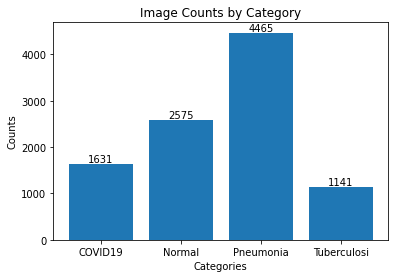

In [ ]:

categories = ['COVID19', 'Normal', 'Pneumonia', 'Tuberculosi']
counts = [1631, 2575, 4465, 1141]

fig, ax = plt.subplots()

rects = ax.bar(categories, counts)
ax.set_xlabel('Categories')
ax.set_ylabel('Counts')
ax.set_title('Image Counts by Category')

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, height, ha='center', va='bottom')

plt.show()


# Pré-processamento de dados



*   Armazenar a imagens no X e Classes no Y
*   Embaralhar 
*   Dividir o grupo de treino e test 
*   Transformar a variavel categorica em binario 






In [6]:
labels = ['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS']

In [7]:
# X são os dados e y suas respctiveis clases 
X_train = []  # Criando e irei addcionar neste diretorio 
y_train = []  # Criando e irei addcionar neste diretorio 
image_size = 224 # Alterando o tamanho da imagem por 224 x 224 para cada item do diretorio 
for i in labels: # Percorrer cada item do diretorio 
    folderPath = os.path.join('/content/drive/MyDrive/Dados/Dados 3','train',i) # Link para abrir a pasta train
    for j in tqdm(os.listdir(folderPath)): #Faça com que seus loops mostrem instantaneamente um medidor de progresso inteligente
        img = cv2.imread(os.path.join(folderPath,j)) #retorna uma matriz 2D ou 3D com base no número de canais de cores presentes na imagem.
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Todas imgaens em RGB da pasta train
        img = cv2.resize(img,(image_size, image_size)) # Alterando o tamanho da imagem por 224 x 224 as todas imagens da pasta train
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dados/Dados 3','test',i) # Link para abrir a pasta train
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # Todas imgaens em RGB da pasta train 
        img = cv2.resize(img,(image_size,image_size)) # Alterando o tamanho da imagem por 224 x 224 as todas imagens da pasta test
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 41/41 [00:34<00:00,  1.18it/s]


In [ ]:
print("Imagens de treino variavel X", X_train.shape)
print("Imagens de treino variavel y", y_train.shape)

Imagens de treino variavel X (9147, 224, 224, 3)
Imagens de treino variavel y (9147,)


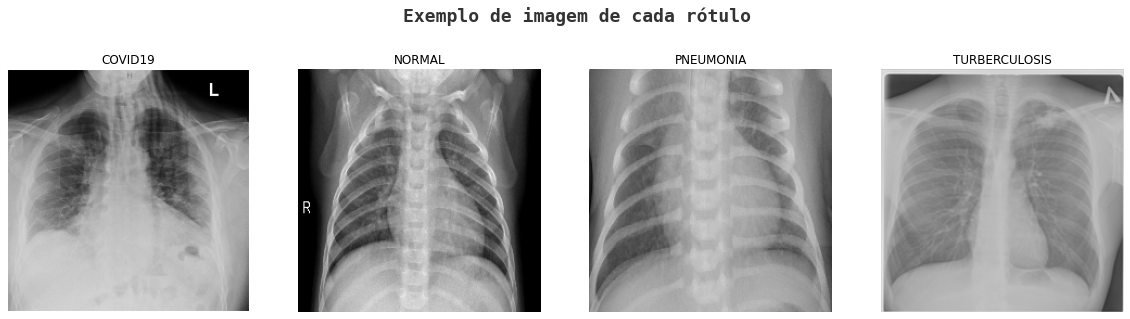

In [ ]:
#  ax criar uma grade de subplots,
#  plt.subplots1,4, linhas e colunas   figsize=(20,20)) tamnhanho

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Exemplo de imagem de cada rótulo',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8) 
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
# serparando os dados de treino e teste, e clases de treino e teste 
#train_test_split vai dividir o dataset em treino e teste 
#test_size vai seprar para o meus teste a porcentagem 
#random_state=101 nivel de aleatoridade, parâmetro controla como os dados são embaralhados antes de serem divididos.


X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)



In [10]:
#Executando One Hot Encoding nos rótulos após convertê-lo em valores numéricos\

#One Hot Encoding é uma representação de variáveis ​​categóricas como vetores binários. 
       #Podemos atribuir a 'vermelho' um valor inteiro de 0 e 'verde' o valor inteiro de 1.

#One-hot encoding é um processo de codificação de dados categóricos, onde uma variável categórica 
#é convertida em um vetor binário com uma única posição a 1 e as demais a 0. Isso é útil quando
#se está trabalhando com algoritmos de aprendizado de máquina que não podem lidar diretamente com
# variáveis categóricas, pois esses algoritmos geralmente esperam valores numéricos.

y_train_new = []
for i in y_train: #para  [item]  em  [sequência] : Execute o  código
    y_train_new.append(labels.index(i)) # adcionou no y_train_new o vetor de as clases do y_train 
y_train = y_train_new # o y_train agora é y_train_new
y_train = tf.keras.utils.to_categorical(y_train) #converter o vetor y_train de classe na matriz da classe binária

# igual de linhas do comprimento do vetor de entrada e o número da coluna que é igual ao número da classe que definimos em nosso código

y_test_new = []
for i in y_test: #para  [item]  em  [sequência] : Execute o  código
    y_test_new.append(labels.index(i)) #adcionou no y_train_new o vetor de as clases do y_train 
y_test = y_test_new # o y_train agora é y_train_new
y_test = tf.keras.utils.to_categorical(y_test)  #converter o vetor y_test de classe na matriz da classe binária



In [ ]:
print("Imagens de Treino variavel X", X_train.shape)
print("Imagens de Treino variavel y", y_train.shape)
print("Imagens de Teste variavel X", X_test.shape)
print("Imagens de Teste variavel y", y_test.shape)

Imagens de Treino variavel X (7317, 224, 224, 3)
Imagens de Treino variavel y (7317, 4)
Imagens de Teste variavel X (1830, 224, 224, 3)
Imagens de Teste variavel y (1830, 4)


# Rede Neural Trans Learning :EfficientNetB6


In [11]:
# Carregando o modelo MobileNetV2 sem as camadas densas
!pip install efficientnet

from tensorflow.keras.applications import EfficientNetB6

conv_base = EfficientNetB6(input_shape=(image_size, image_size, 3),
                           include_top=False,
                           weights='imagenet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.9 MB/s eta 0:00:00
165234480/165234480 [==============================] - 8s 0us/step


In [ ]:
conv_base.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
visualkeras.layered_view(conv_base)

In [20]:
model = Sequential()
model.add(EfficientNetB6(input_shape=(image_size, image_size, 3),
                           include_top=False,
                           weights='imagenet'))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 7, 7, 2304)       40960143  
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               14450816  
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 55,435,987
Trainable params: 14,475,844
No

In [21]:
#Hyperparametros

#O otimizador é uma parte crucial do treinamento de uma rede neural. Ele é responsável 
#por ajustar os pesos da rede ao longo do tempo para que a função de perda seja minimizada. 
#Em outras palavras, o otimizador é o que permite que o modelo aprenda a partir dos dados.


#Compilar o modelo (definir o algoritimo a computar os gradientes, as metricas capazes de avaliar erros, e a função de erro  )

model.compile(loss='categorical_crossentropy', # A função de perda vai calcular o tanto que a rede esta errando, a diferença do resultado ideal com quanto a rede esta oferencendo na pratica,,
                                               # Saida é uma probalidade. Usado como uma função de perda para o modelo de classificação multiclasse onde há dois ou mais rótulos de saída.
              optimizer = 'Adam', # Quem vai fazer os calculos para ajustar os pessos da rede neural 
              metrics= ['accuracy']) # A precisão é uma medida de quão bem o modelo está realizando suas previsões e é uma das métricas mais comuns usadas para avaliar o desempenho de um modelo de classificação

In [22]:
#TensorBoard: medidas e visualizações necessárias durante o fluxo de trabalho de aprendizado de máquina.
             # Ele permite rastrear métricas de experimentos como perda e precisão, visualizar o gráfico do modelo

#ModelCheckpoint : salvar um modelo ou pesos (em um arquivo de ponto de verificação) em algum intervalo,
                  #para que o modelo ou os pesos possam ser carregados posteriormente para continuar o treinamento a partir do estado salvo.
                  #save_best_only = Salvar o melhor modelo #verbose= mostra a barra de progresso #mode = queremos monitorar o "val_accurracy

#ReduceLROnPlateau:  Este retorno de chamada monitora uma quantidade e se nenhuma melhora for observada por um número de 'paciência' 
                     # de épocas, a taxa de aprendizado é reduzida

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', #monitor = metrica a ser monitorada 
                              factor = 0.1, #fator pelo qual a taxa de aprendizado será reduzida.
                              patience = 2, #número de épocas sem melhora após as quais a taxa de aprendizado será reduzida.
                              min_delta = 0.001, #limite para medir o novo ótimo, para focar apenas em mudanças significativas.
                              mode='auto',verbose=1) # verbose= mostra a barra de progresso, mode = queremos monitorar o "val_accurracy" queremo valor maximo

In [24]:
batch_size   = 32
input_shape  = (224,224,3)
random_state = 42
alpha        = 1e-5
epoch        = 25

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir = 'logs')

callbacks = [checkpoint, lr_reduce, tensorboard]


# Treianando a rede neural

In [25]:
# Fazendo a rede aprender na pratica 

hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1, 
                 epochs =15, # 15  epocas 
                 verbose=1, #mostra a barra de progresso
                 batch_size=32, # configura  a  quantidade  de imagens por lote no processamento, Vai processar de 32 imagens por vez 
                  callbacks=[tensorboard,checkpoint,reduce_lr] # definidos anteriormente 
                 )

Epoch 1/15
206/206 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9368

206/206 [==============================] - 63s 303ms/step - loss: 0.1929 - accuracy: 0.9368 - val_loss: 0.3191 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/15
206/206 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9569

206/206 [==============================] - 63s 306ms/step - loss: 0.1292 - accuracy: 0.9569 - val_loss: 0.1020 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 3/15
206/206 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9601

206/206 [==============================] - 59s 285ms/step - loss: 0.1167 - accuracy: 0.9601 - val_loss: 0.1843 - val_accuracy: 0.9426 - lr: 0.0010
Epoch 4/15
206/206 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9585


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
206/206 [==============================] - 59s 286ms/step - loss: 0.1318 - accuracy: 0.9585 - val_loss: 0.3305 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 5/15
206/206 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9763

206/206 [==============================] - 64s 309ms/step - loss: 0.0675 - accuracy: 0.9763 - val_loss: 0.1090 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 6/15
206/206 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9841

206/206 [==============================] - 59s 286ms/step - loss: 0.0439 - accuracy: 0.9841 - val_loss: 0.0876 - val_accuracy: 0.9713 - lr: 1.0000e-04
Epoch 7/15
206/206 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9857

206/206 [==============================] - 59s 287ms/step - loss: 0.0409 - accuracy: 0.9857 - val_loss: 0.0916 - val_accuracy: 0.9658 - lr: 1.0000e-04
Epoch 8/15
206/206 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9885


Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
206/206 [==============================] - 59s 287ms/step - loss: 0.0330 - accuracy: 0.9885 - val_loss: 0.0831 - val_accuracy: 0.9658 - lr: 1.0000e-04
Epoch 9/15
206/206 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9912

206/206 [==============================] - 59s 288ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.0779 - val_accuracy: 0.9713 - lr: 1.0000e-05
Epoch 10/15
206/206 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9901


Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
206/206 [==============================] - 59s 288ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0829 - val_accuracy: 0.9699 - lr: 1.0000e-05
Epoch 11/15
206/206 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9909

206/206 [==============================] - 59s 288ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0825 - val_accuracy: 0.9686 - lr: 1.0000e-06
Epoch 12/15
206/206 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9898


Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
206/206 [==============================] - 59s 288ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.0818 - val_accuracy: 0.9686 - lr: 1.0000e-06
Epoch 13/15
206/206 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9888

206/206 [==============================] - 59s 288ms/step - loss: 0.0306 - accuracy: 0.9888 - val_loss: 0.0818 - val_accuracy: 0.9686 - lr: 1.0000e-07
Epoch 14/15
206/206 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9898


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
206/206 [==============================] - 64s 310ms/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.0818 - val_accuracy: 0.9686 - lr: 1.0000e-07
Epoch 15/15
206/206 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9907

206/206 [==============================] - 59s 287ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0818 - val_accuracy: 0.9686 - lr: 1.0000e-08


# Resulatados da rede neural

In [26]:
results = model.evaluate(X_train,y_train)

229/229 [==============================] - 58s 252ms/step - loss: 0.0251 - accuracy: 0.9923


In [27]:
results2 = model.evaluate(X_test,y_test)

58/58 [==============================] - 15s 260ms/step - loss: 0.1480 - accuracy: 0.9612


In [28]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


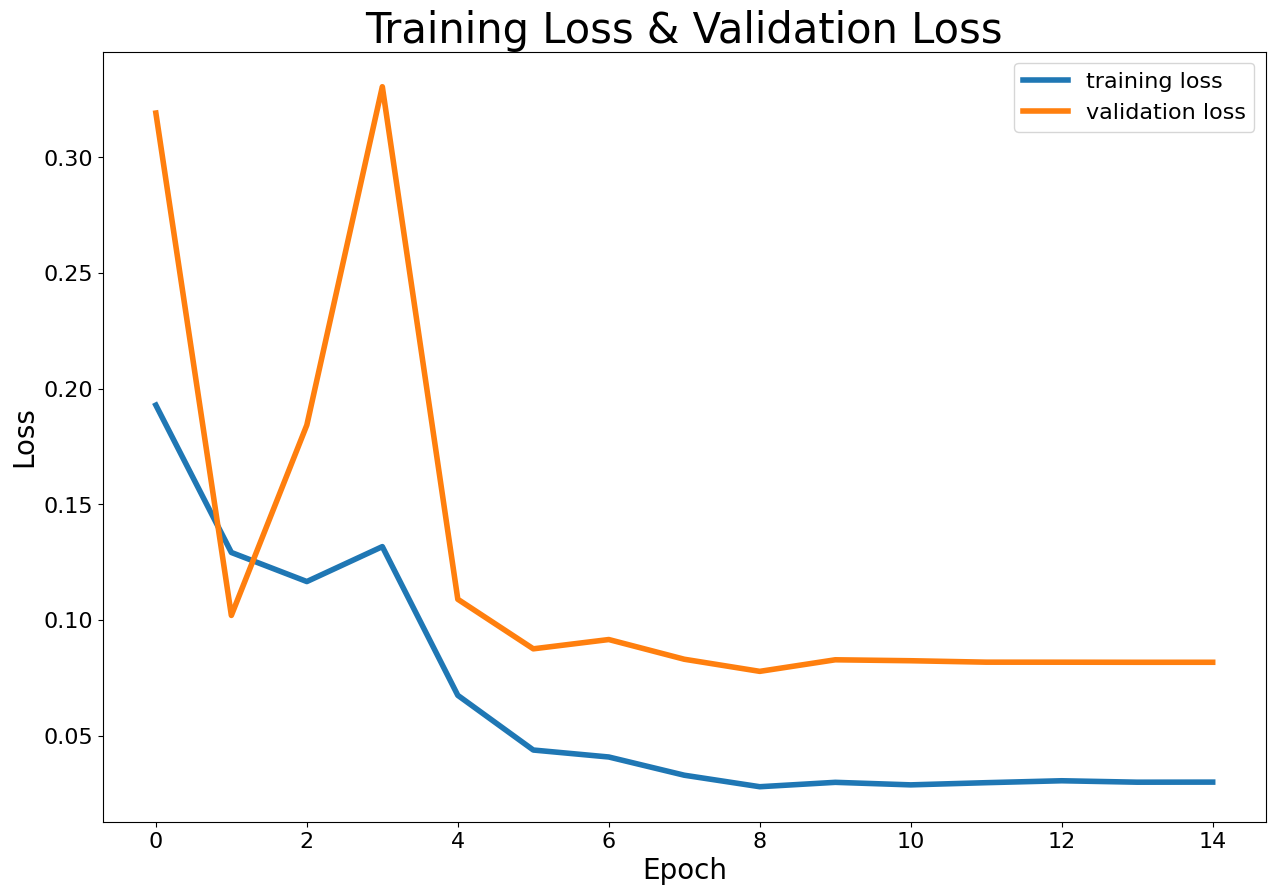

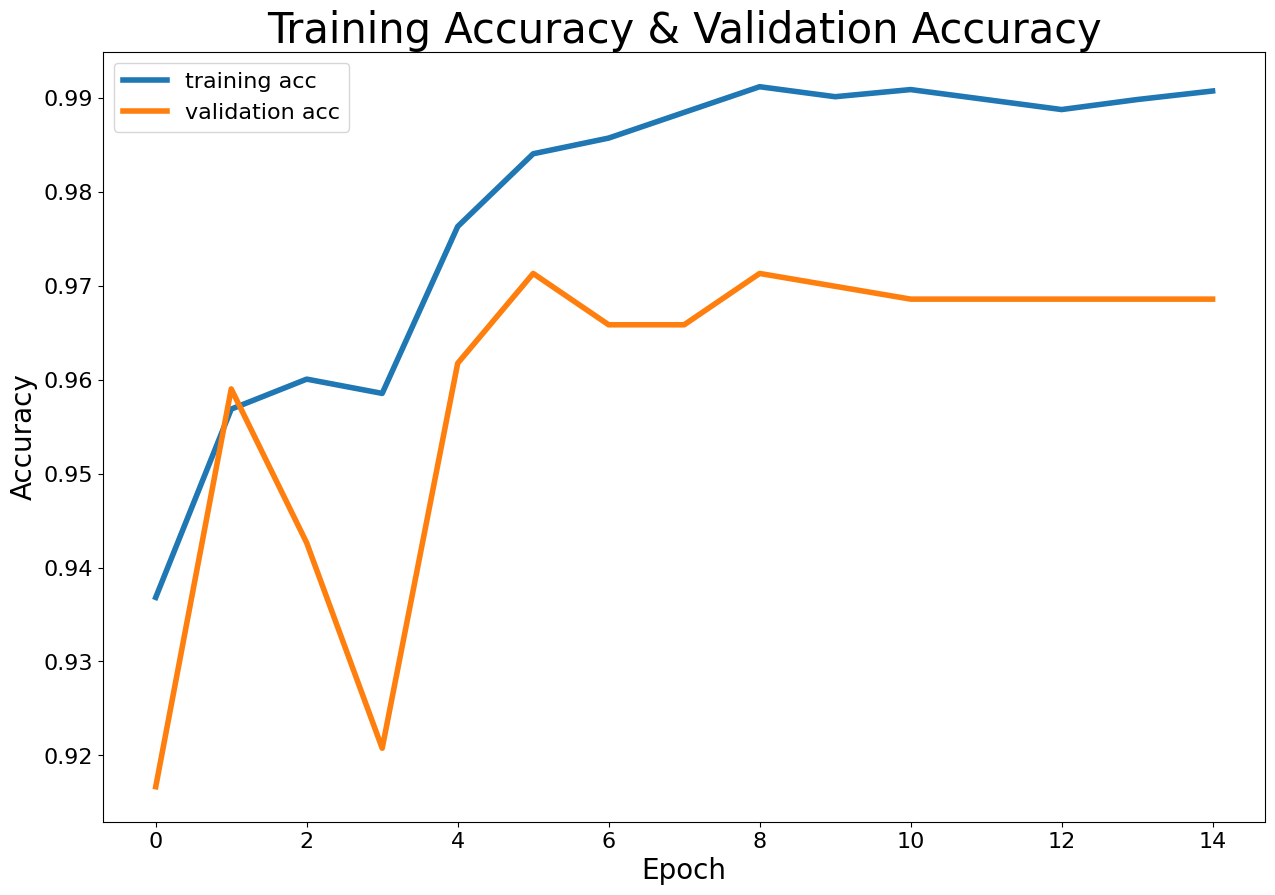

In [29]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss", linewidth=4)
plt.plot(hist.history["val_loss"],label = "validation loss", linewidth=4)
plt.title("Training Loss & Validation Loss", fontsize=30)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc", linewidth=4)
plt.plot(hist.history["val_accuracy"],label = "validation acc", linewidth=4)
plt.title("Training Accuracy & Validation Accuracy", fontsize=30)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()


In [30]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

58/58 [==============================] - 18s 234ms/step


In [31]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       199
           1       0.94      0.95      0.94       528
           2       0.97      0.96      0.97       875
           3       0.98      0.99      0.98       228

    accuracy                           0.96      1830
   macro avg       0.97      0.96      0.96      1830
weighted avg       0.96      0.96      0.96      1830



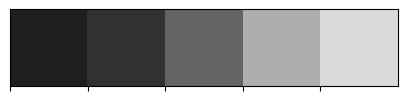

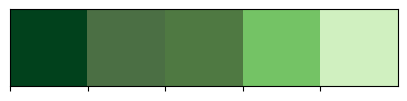

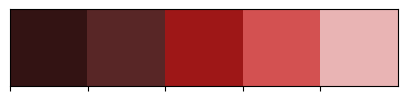

In [32]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

[[188   2   4   5]
 [  1 504  23   0]
 [  1  33 841   0]
 [  2   0   0 226]]


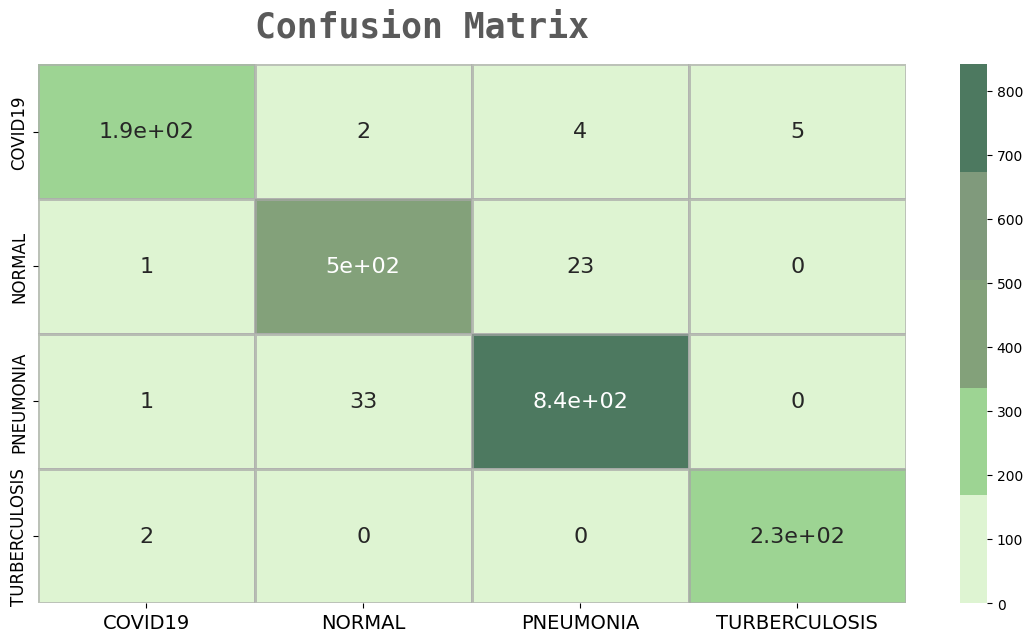

In [33]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3],
            annot_kws={"fontsize": 16}, # tamanho da fonte dos resultados
            )
ax.tick_params(axis='both', which='major', labelsize=14) # tamanho da fonte dos eixos x e y
ax.set_xticklabels(labels, fontsize=14) # tamanho da fonte das barras laterais x
ax.set_yticklabels(labels, fontsize=12) # tamanho da fonte das barras laterais y
fig.text(s='Confusion Matrix',
         size=25,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()

[[188   2   4   5]
 [  1 504  23   0]
 [  1  33 841   0]
 [  2   0   0 226]]


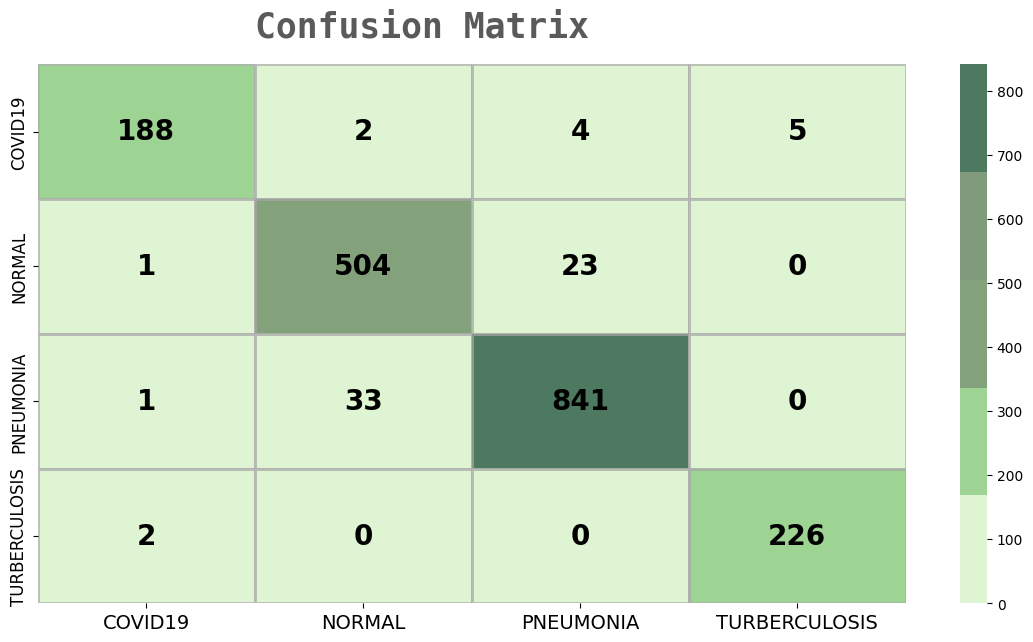

In [34]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new, pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3],
            annot_kws={"fontsize": 20, "fontweight": "bold", "color": "black"},
            fmt=".0f"
            )
ax.tick_params(axis='both', which='major', labelsize=14) # tamanho da fonte dos eixos x e y
ax.set_xticklabels(labels, fontsize=14) # tamanho da fonte das barras laterais x
ax.set_yticklabels(labels, fontsize=12) # tamanho da fonte das barras laterais y
fig.text(s='Confusion Matrix',
         size=25,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()

# Baixando os resultados para fazer assemble


In [35]:
# obter as previsões para cada imagem de teste
y_pred = model.predict(X_test)

# obter a classe prevista para cada imagem de teste (classe com maior probabilidade)
y_pred_classes = y_pred.argmax(axis=-1)

# armazenar as previsões em uma matriz
predictions = y_pred_classes.reshape(-1, 1)

import pandas as pd

# criar um DataFrame a partir da matriz de previsões
df_predictions = pd.DataFrame(predictions, columns=['Predicted Class'])

# imprimir o DataFrame
print(df_predictions)

58/58 [==============================] - 13s 230ms/step
      Predicted Class
0                   0
1                   1
2                   2
3                   1
4                   2
...               ...
1825                2
1826                1
1827                1
1828                2
1829                1

[1830 rows x 1 columns]


In [36]:
from google.colab import files
import pandas as pd

# criar um DataFrame a partir da matriz de previsões
df_predictions = pd.DataFrame(predictions, columns=['Predicted Class'])

# salvar o DataFrame em um arquivo Excel
df_predictions.to_excel('predictions.xlsx', index=False)

# baixar o arquivo para o seu computador
files.download('predictions.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import numpy as np

# Encontra o índice do valor máximo em cada linha da matriz
y_test_pred = np.argmax(y_test, axis=1)

# Transforma o vetor unidimensional em um vetor coluna
y_test_pred_col = y_test_pred.reshape(-1, 1)

from google.colab import files

# Transforma o vetor unidimensional em um vetor coluna
y_test_pred_col = y_test_pred.reshape(-1, 1)

# Cria um DataFrame a partir do vetor coluna
df_y_test_pred = pd.DataFrame(y_test_pred_col, columns=['Predicted Class'])

# Escreve o DataFrame em um arquivo Excel
filename = 'y_test_pred.xlsx'
df_y_test_pred.to_excel(filename, index=False)

# Baixa o arquivo Excel para o computador
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>